<a href="https://colab.research.google.com/github/Imraneouelfaquir98/AI-Application-using-sklearn-library/blob/main/SDDP_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!unzip /content/drive/MyDrive/Internship/Laval\ University/SolutionDatasetRC101V2.zip

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset preprocessing
## Visualizing dataset

Displaying the first 10 rows of a sample dataset

In [5]:
df = pd.read_csv('/content/SolutionDatasetRC101/1_record_2.csv')
df.head(10)

,ID Cleint,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,DriverCount,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,Coord X,88,35,10,30,66,28,18,87,2,22,47,90,25,45,42,25,28,15,40,85,22,28,92,58,48,65,0,48,42,5,38,38,45,50,88,33,55,42,53,20,68,65,45,70
2,Coord Y,35,32,35,50,55,30,75,30,40,75,35,35,35,65,66,85,52,80,5,35,85,35,30,75,30,60,45,40,65,45,68,15,30,35,30,32,80,15,35,85,60,55,70,58
3,Arr,16,19,24,43,45,55,62,70,79,87,88,91,126,142,142,158,167,173,191,203,215,227,230,238,252,304,317,321,330,331,339,342,355,357,357,371,385,415,439,440,441,441,459,461
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Loading Datase : 
Upload 1000 files of same-day delivery problem scenarios solved by Branch And Regret algorithm and paste them into one dataframe

The data set consists of 200 scenarios for each number of drivers from 1 to 5.

In [6]:
df = df.T
df = df.rename(columns=df.iloc[0])
df = df.drop([df.index[0]])

In [7]:
for i in range(1,1000):
  df_tmp = pd.read_csv('/content/SolutionDatasetRC101/'+str(i+1)+'_record_2.csv')
  df_tmp = df_tmp.T
  df_tmp = df_tmp.rename(columns=df_tmp.iloc[0])
  df_tmp = df_tmp.drop([df_tmp.index[0]])
  df = df.append(df_tmp)
  if i% 200 == 0:
    print(i, '\tDriver Count = ',i% 200+1)

200 	Driver Count =  1
400 	Driver Count =  1
600 	Driver Count =  1
800 	Driver Count =  1


In [8]:
df.head()

,DriverCount,Coord X,Coord Y,Arr,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,Y
1,1,88,35,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,35,32,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,10,35,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,30,50,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,1,66,55,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Grouping dataset by label Y and DriverCount
We are going to calculate the number of observations for each number in DriverCount {1, ..., 5}

In [9]:
sum    = df.groupby(['DriverCount']).sum()['Y']
values = df['DriverCount'].value_counts()

count = list()
for i in range(5):
  count.append(values[sum.index[i]] - sum[sum.index[i]])
  count.append(sum[sum.index[i]])

percentage = list()
for i in range(5):
  percentage.append(100*(values[sum.index[i]] - sum[sum.index[i]])/values[sum.index[i]])
  percentage.append(100*sum[sum.index[i]]/values[sum.index[i]])

Here is the grouped dataframe that contains the number and percentage of purchases accepted and reused for each number of drivers

In [10]:
df_grouped = df.groupby(['DriverCount', 'Y']).sum()[['Arr']]
df_grouped.insert(0, "Percentage %", percentage)
df_grouped.insert(0, "Count accepted", count)
df_grouped[['Count accepted', 'Percentage %']]

Count accepted  Percentage %
DriverCount Y                              
1           0            4268     55.587393
            1            3410     44.412607
2           0            2307     30.359258
            1            5292     69.640742
3           0            1147     15.092105
            1            6453     84.907895
4           0             554      7.153926
            1            7190     92.846074
5           0             242      3.166710
            1            7400     96.833290

## Plot a bar chart of the grouped dataframe
Once we have calculated the number and percentage of purchases accepted and declined for each number of drivers, it would be best to draw a bar chart to show the relationship between the number of drivers and the acceptance of purchases.

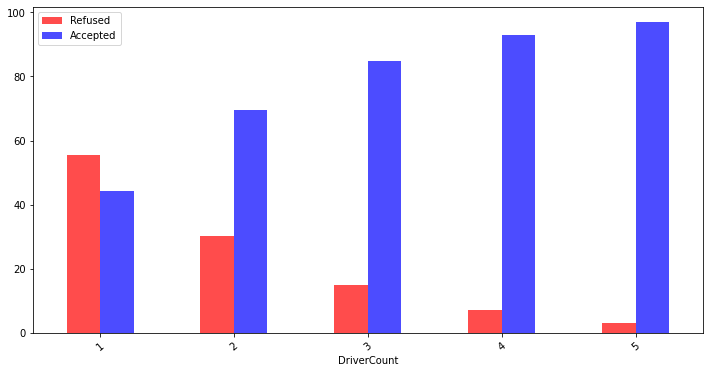

In [11]:
percentage_0 = list()
percentage_1 = list()
for i in range(5):
  percentage_0.append(df_grouped.iloc[2*i  ][1])
  percentage_1.append(df_grouped.iloc[2*i+1][1])
new_df = pd.DataFrame({'DriverCount':[1,2,3,4,5], 'Refused':percentage_0, 'Accepted':percentage_1})
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
new_df.plot.bar(x = 'DriverCount', y = ['Refused', 'Accepted'], ax=ax, color=['red', 'blue'], rot = 40, alpha=0.7)

## We can also plot a bar chart for class distribution

In [12]:
# x = np.array(["0","1"])
# plt.rcParams["figure.figsize"] = (8,5)
# plt.bar(x, df.groupby(['Y']).count()['DriverCount'].to_numpy())
# plt.show()

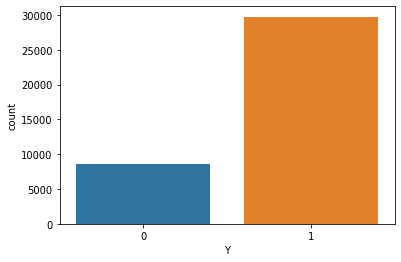

In [13]:
sns.countplot(x = 'Y', data=df)

As shown in the graph above, we lack data for label 0, we face the unbalanced data problem. In the remaining, we will build a deep neural network to fit the dataset, then we will try to apply different methods used for the unbalanced data problem and compare the difference.

# Deep Neural Network

## Import Libraries

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Create Input and Output Data

In [15]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

## Train Test Split
We now split our data into train and test sets. We’ve selected 20% percent of out data to be in the test set.


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=69)

## Model Parameters
To train our models, we need to set some hyper-parameters which are the number of epochs, the bach size and the learning rate

In [17]:
EPOCHS = 1000
BATCH_SIZE = 512
LEARNING_RATE = 0.001

## Define Custom Dataloaders for training and testing dataset



In [18]:
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)

class TestData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
    def __getitem__(self, index):
        return self.X_data[index]
    def __len__ (self):
        return len(self.X_data)

In [19]:
X_train = torch.FloatTensor(X_train.astype(np.float).to_numpy())
X_test  = torch.FloatTensor(X_test .astype(np.float).to_numpy())

train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = TestData(torch.FloatTensor(X_test))

In [32]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

## Define Neural Net Architecture

The architecture of our neural network is defined as follows, since the number of input features in our dataset is 104, the input to our first nn.Linear layer would be 104. The output will be 1 since the problem is a binary classification. For the hidden layers we add two layers each composed of 128 neurons.

In [20]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(104, 128) 
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, 128)
        self.layer_out = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(128)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

### We are working in google Colab where there is a GPU available so we can train our model in a GPU for better performance

In [28]:
device = torch.device("cuda:0")
print(device)

cuda:0


Next, we need to initialize our model

In [29]:
model = BinaryClassification()
model.to(device)
print(model)

BinaryClassification(
  (layer_1): Linear(in_features=104, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [34]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train the model
defining a function to calculate accuracy.

In [30]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

Fitting the model in the dataset

In [35]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f}')

Epoch 001: | Loss: 0.48085
Epoch 002: | Loss: 0.31798
Epoch 003: | Loss: 0.27575
Epoch 004: | Loss: 0.25566
Epoch 005: | Loss: 0.24606
Epoch 006: | Loss: 0.23814
Epoch 007: | Loss: 0.23349
Epoch 008: | Loss: 0.22985
Epoch 009: | Loss: 0.22651
Epoch 010: | Loss: 0.22123
Epoch 011: | Loss: 0.21944
Epoch 012: | Loss: 0.21920
Epoch 013: | Loss: 0.21607
Epoch 014: | Loss: 0.21431
Epoch 015: | Loss: 0.21274
Epoch 016: | Loss: 0.20816
Epoch 017: | Loss: 0.20623
Epoch 018: | Loss: 0.20660
Epoch 019: | Loss: 0.20480
Epoch 020: | Loss: 0.20043
Epoch 021: | Loss: 0.19962
Epoch 022: | Loss: 0.20179
Epoch 023: | Loss: 0.19805
Epoch 024: | Loss: 0.19748
Epoch 025: | Loss: 0.19319
Epoch 026: | Loss: 0.19150
Epoch 027: | Loss: 0.19254
Epoch 028: | Loss: 0.18962
Epoch 029: | Loss: 0.19279
Epoch 030: | Loss: 0.18762
Epoch 031: | Loss: 0.18741
Epoch 032: | Loss: 0.18296
Epoch 033: | Loss: 0.17914
Epoch 034: | Loss: 0.18475
Epoch 035: | Loss: 0.18236
Epoch 036: | Loss: 0.18231
Epoch 037: | Loss: 0.17436
E

## Test the model

In [36]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [74]:
y_test = list(y_test)

In [75]:
ypredlist = np.array(y_pred_list).astype(np.int)
ypredlist = list(ypredlist)

In [76]:
confusion_matrix(y_test, y_pred_list)

array([[1300,  386],
       [ 303, 5664]])

In [77]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1686
           1       0.94      0.95      0.94      5967

    accuracy                           0.91      7653
   macro avg       0.87      0.86      0.87      7653
weighted avg       0.91      0.91      0.91      7653



As a result we have an accuracy percentage of 81% for class 0 and 94% for class 1, we will get a better result if we train our model in more epochs and with a more deep learning architecture complicated.